### Summary    

작성일 : 19/09/05  

<목적>  
주소 변수(addr1, addr2) 와 다른 변수들간의 관계를 통해 feature 생성의 idea 생성  

<방법>
- addr2, addr1 별로 Top 10의 value_counts 항목들 추출
- 해당 항목들과 date, ProductCD, TransactionAmt, card1, card3

### 데이터 전처리

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc, datetime, time
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_idf = pd.read_pickle('/home/jeong/kaggle/IEEE/input/train_identity.pkl')
tr = pd.read_pickle('/home/jeong/kaggle/IEEE/input/train_transaction.pkl')

test_idf =pd.read_pickle('/home/jeong/kaggle/IEEE/input/test_identity.pkl')
te = pd.read_pickle('/home/jeong/kaggle/IEEE/input/test_transaction.pkl')

In [3]:
print("train addr2, addr1")
print(" ")
print(tr.addr2.value_counts().nlargest(5))
print(tr.addr1.value_counts().nlargest(5))

print(" ")
print("test addr2, addr1")
print(" ")
print(te.addr2.value_counts().nlargest(5))
print(te.addr1.value_counts().nlargest(5))

train addr2, addr1
 
87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
Name: addr2, dtype: int64
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
Name: addr1, dtype: int64
 
test addr2, addr1
 
87.0    435934
60.0      4041
96.0       608
32.0        61
65.0        49
Name: addr2, dtype: int64
299.0    38710
204.0    35049
325.0    34151
264.0    32710
330.0    22100
Name: addr1, dtype: int64


In [4]:
tr = tr[tr['addr2']== 87]
te = te[te['addr2']== 87]

In [5]:
ex = te.addr1.value_counts().nlargest(10).reset_index()
ex.columns = ['addr1', 'cnt']
top10 = ex['addr1'].values.tolist()

tr = tr[tr['addr1'].isin(top10) ]
te = te[te['addr1'].isin(top10) ]

- addr2는 국가, addr1는 지역(주최측에서 설명한 description에 따르면)
- addr2 90% 이상의 값이 87(미국으로 추정)이므로 addr2==87인 데이터와, 데이터 분포 파악 용이를 위해 addr1 Top10만 추출

### 1.  isFraud ratio by addr1

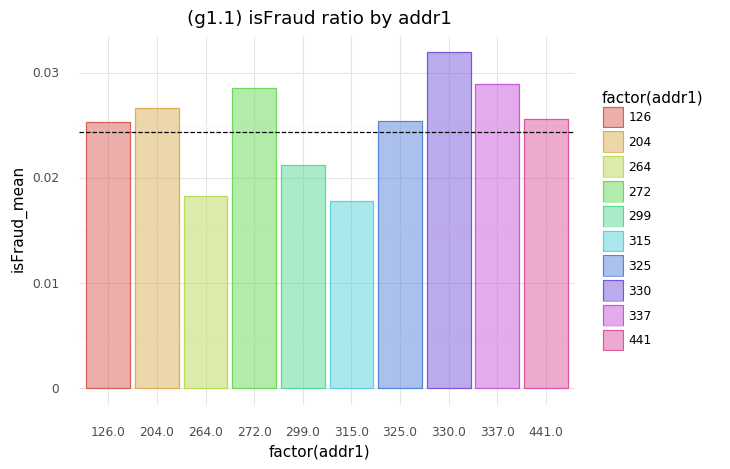

<ggplot: (-9223363266386613700)>


In [7]:
temp = tr.groupby('addr1').isFraud.mean().reset_index()
temp.columns = ['addr1', 'isFraud_mean']
p = ggplot(temp, aes('factor(addr1)','isFraud_mean', fill = 'factor(addr1)', color = 'factor(addr1)' )) + geom_col(alpha = 0.5) + geom_hline(yintercept = tr.isFraud.mean() , colour="black", linetype="dashed") +  \
    theme_minimal() + ggtitle('(g1.1) isFraud ratio by addr1')
print(p)

### 2. addr1 vs ProductCD

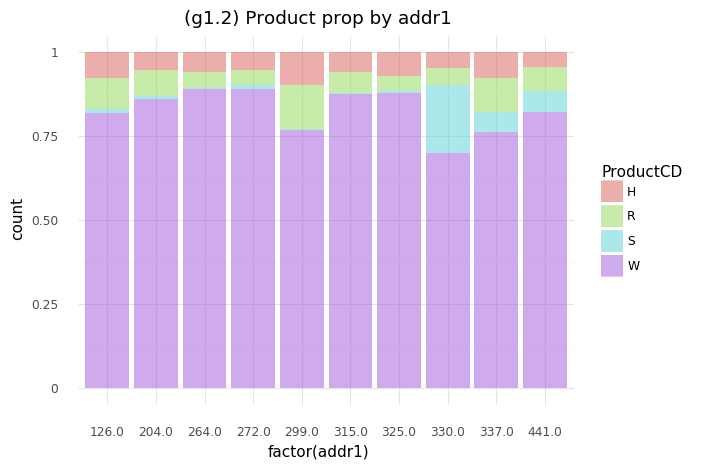

<ggplot: (-9223363266380325681)>


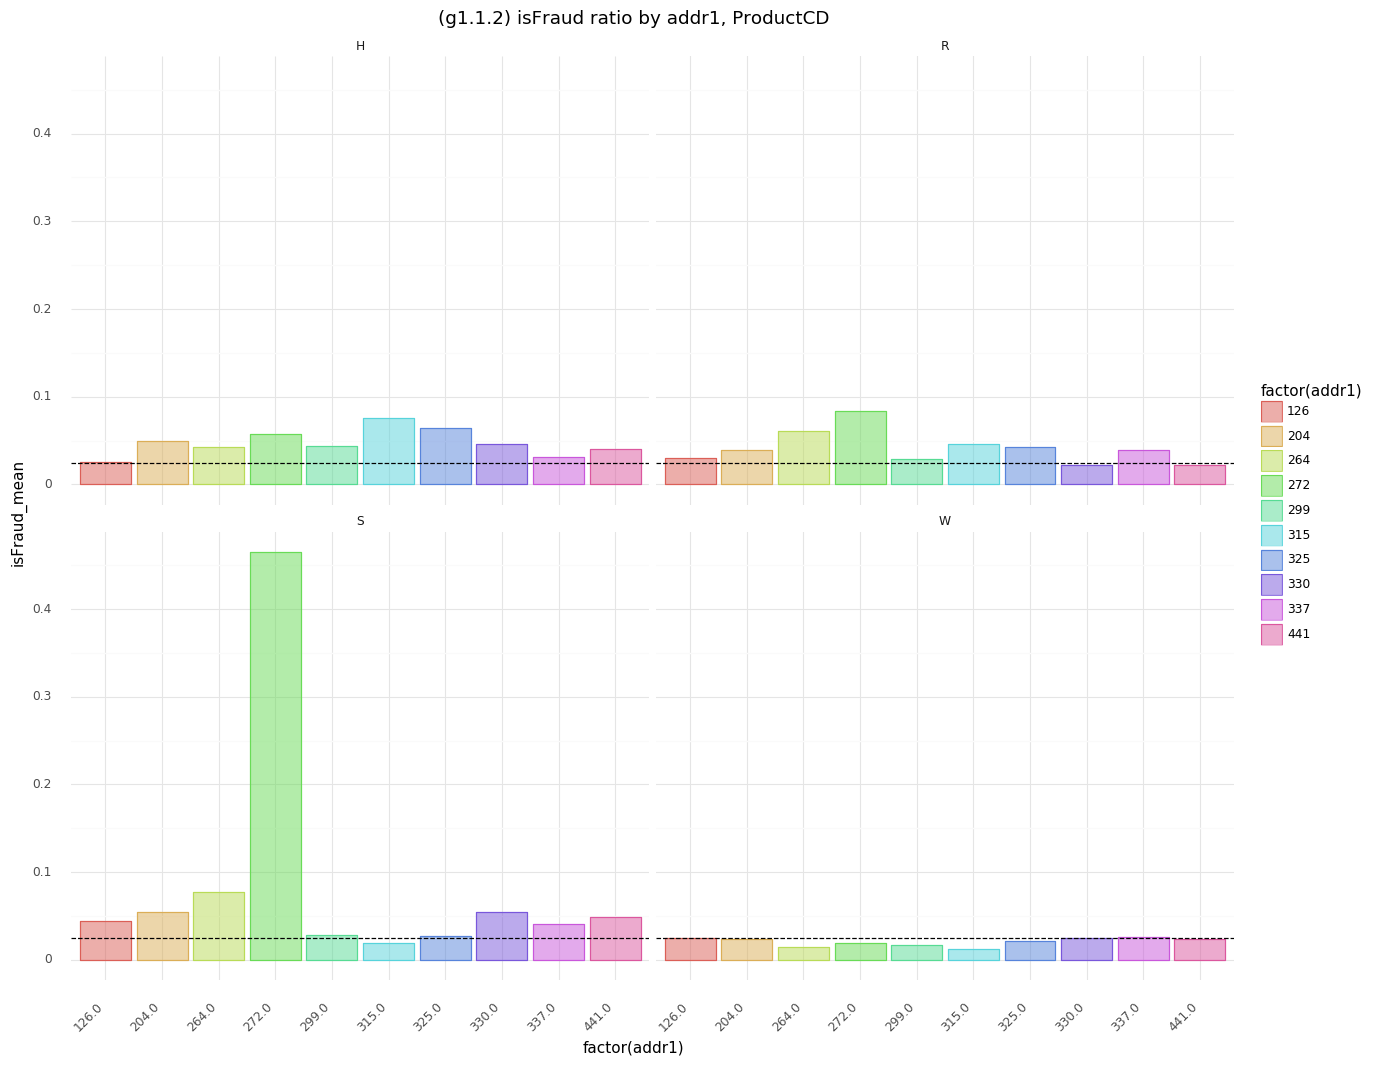

<ggplot: (-9223363266398391222)>


In [8]:
p = ggplot(tr, aes('factor(addr1)', fill = 'ProductCD' )) + geom_bar(alpha = 0.5, position = 'fill') +   \
    theme_minimal() + ggtitle('(g1.2) Product prop by addr1')
print(p)


temp = tr.groupby(['addr1','ProductCD']).isFraud.mean().reset_index()
temp.columns = ['addr1','ProductCD', 'isFraud_mean']
p = ggplot(temp, aes('factor(addr1)','isFraud_mean', fill = 'factor(addr1)', color = 'factor(addr1)' )) + geom_col(alpha = 0.5) + geom_hline(yintercept = tr.isFraud.mean() , colour="black", linetype="dashed") +  \
    theme_minimal() + ggtitle('(g1.1.2) isFraud ratio by addr1, ProductCD') + facet_wrap("ProductCD") + theme(figure_size = (15, 12)) + theme(axis_text_x=element_text(rotation=45, hjust=1))
print(p)

- 330, 337, 441의 경우 S의 비중이 높았으며, 299, 337, 441의 경우 H와 R의 비중이 높았음  
- 특히 330은 S의 비중이 더 높았으며, S의 높은 isFraud가 (g1.1)의 높은 Fraud ratio의 일정 부분을 차지  
- 272에서 S의 매우 높은 Fraud ratio...?

### 3. addr1 vs TransactionAmt

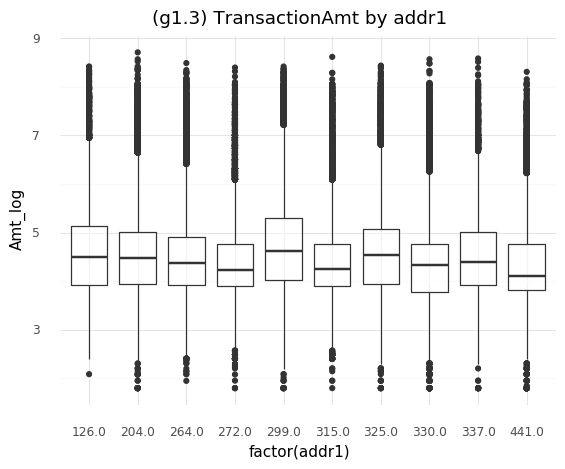

<ggplot: (8731794351985)>


In [42]:
tr['Amt_log'] = np.log(tr['TransactionAmt']+1)
p = ggplot(tr, aes('factor(addr1)', y = 'Amt_log', fill = 'TransactionAmt' )) + geom_boxplot(alpha = 0.5) +   \
    theme_minimal() + ggtitle('(g1.3) TransactionAmt by addr1')
print(p)

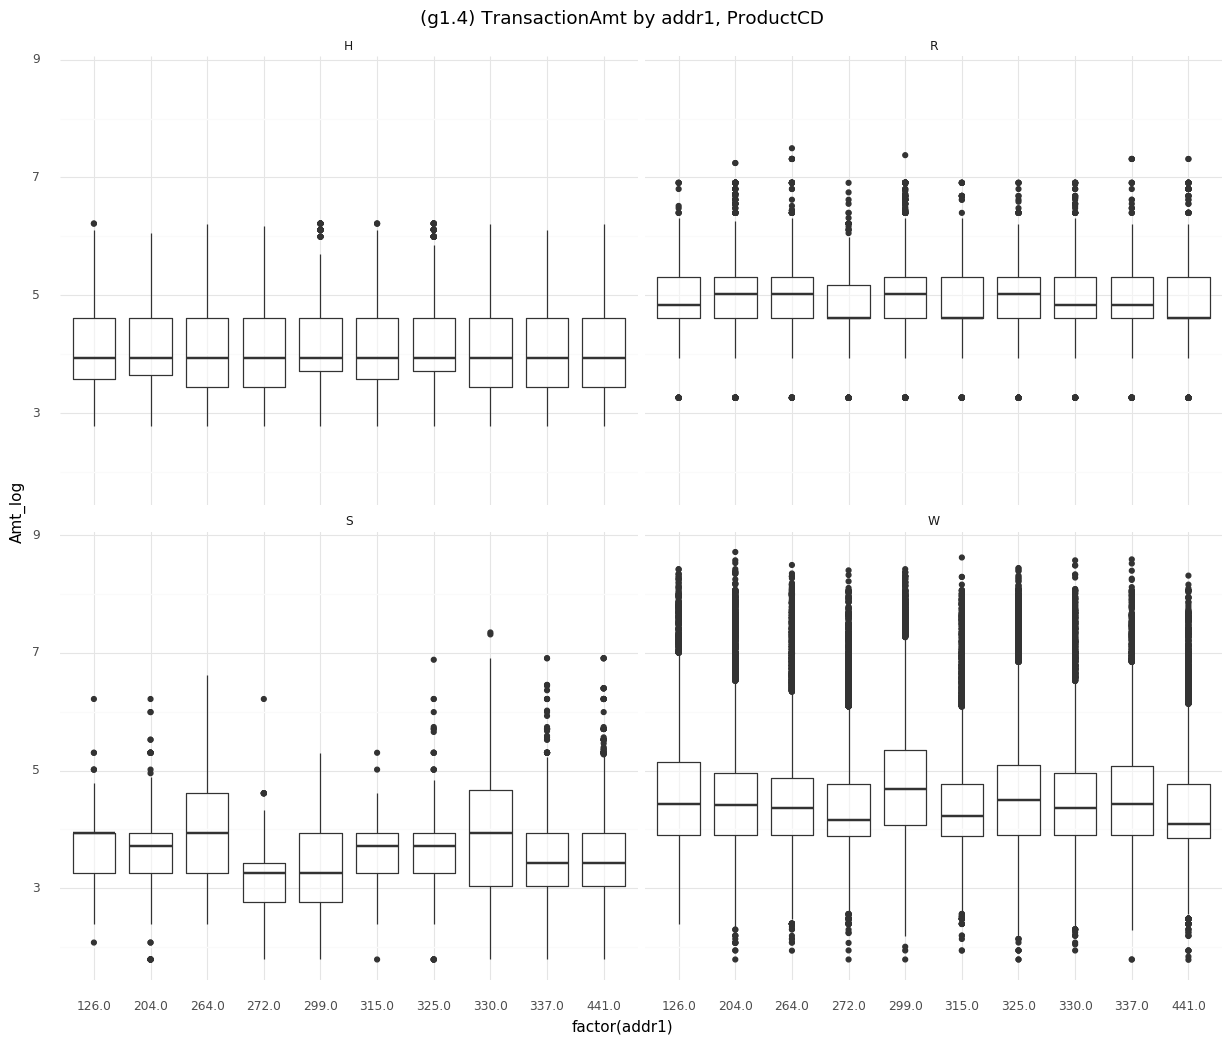

<ggplot: (8731780181533)>


In [44]:
p = ggplot(tr, aes('factor(addr1)', y = 'Amt_log', fill = 'TransactionAmt' )) + geom_boxplot(alpha = 0.5) +   \
    theme_minimal() + ggtitle('(g1.4) TransactionAmt by addr1, ProductCD') + facet_wrap('ProductCD') + theme(figure_size=(15, 12))
print(p)

- S의 경우 TransactionAmt의 평균이나 variance 값의 차이들이 보임  
- (가설 : variance가 크면, Fraud 비율도 증가하지않을까? )

### 4. addr1 vs dist

4.1. overview

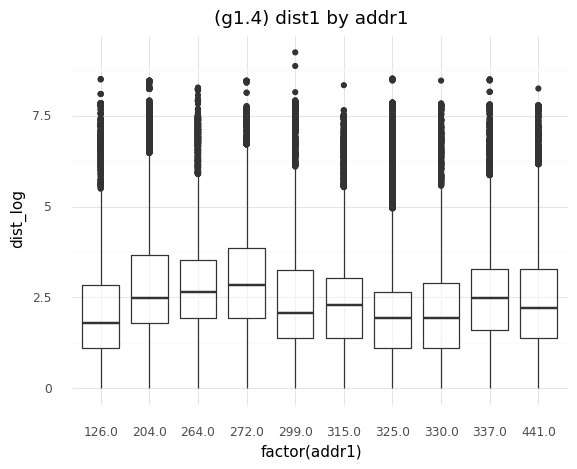

<ggplot: (8731781190741)>


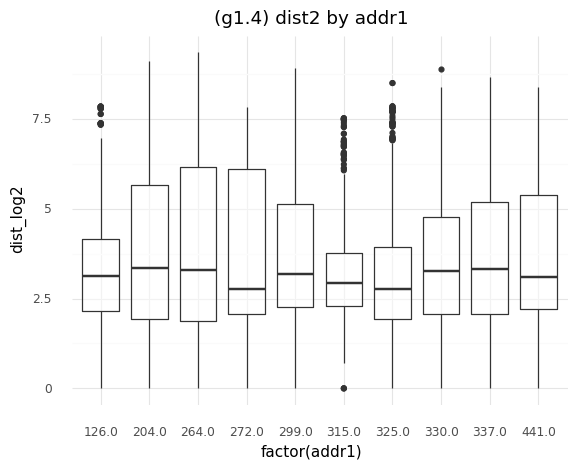

<ggplot: (-9223363305074217149)>


In [61]:
tr['dist_log'] = np.log(tr['dist1']+1)
tr['dist_log2'] = np.log(tr['dist2']+1)
p = ggplot(tr, aes('factor(addr1)', y = 'dist_log', fill = 'TransactionAmt' )) + geom_boxplot(alpha = 0.5) +   \
    theme_minimal() + ggtitle('(g1.4) dist1 by addr1')
print(p)
p = ggplot(tr, aes('factor(addr1)', y = 'dist_log2', fill = 'TransactionAmt' )) + geom_boxplot(alpha = 0.5) +   \
    theme_minimal() + ggtitle('(g1.4) dist2 by addr1')
print(p)

4.2. addr1 + dist1/2 + ProductCD

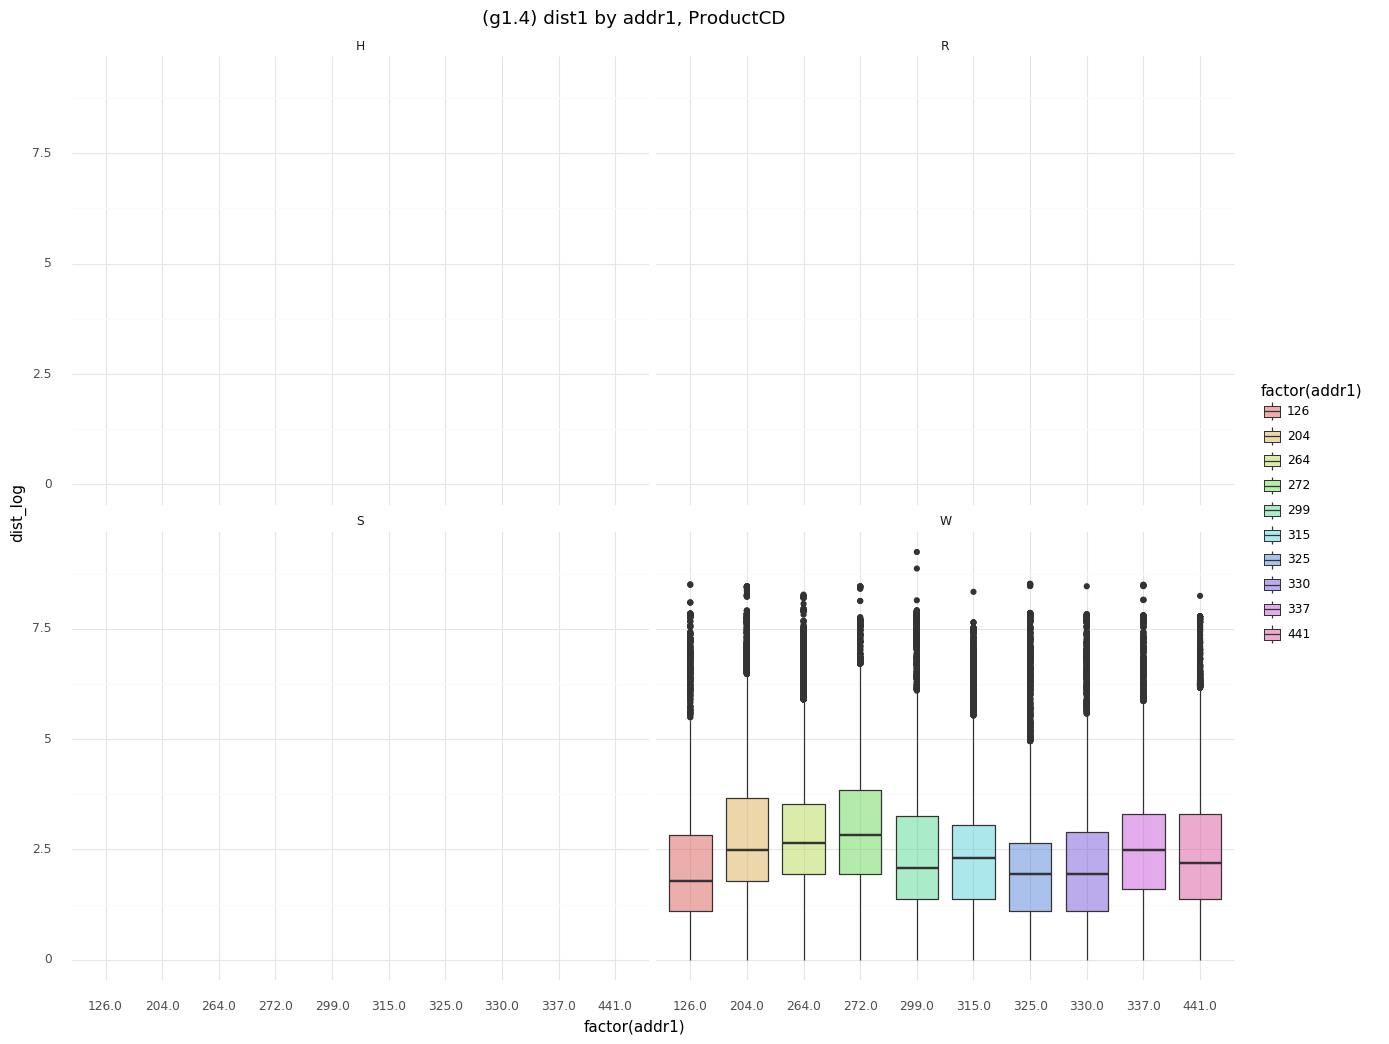

<ggplot: (-9223363305074690325)>


In [62]:
p = ggplot(tr, aes('factor(addr1)', y = 'dist_log', fill = 'factor(addr1)' )) + geom_boxplot(alpha = 0.5) +   \
    theme_minimal() + ggtitle('(g1.4) dist1 by addr1, ProductCD') + facet_wrap('ProductCD') + theme(figure_size=(15, 12))
print(p)

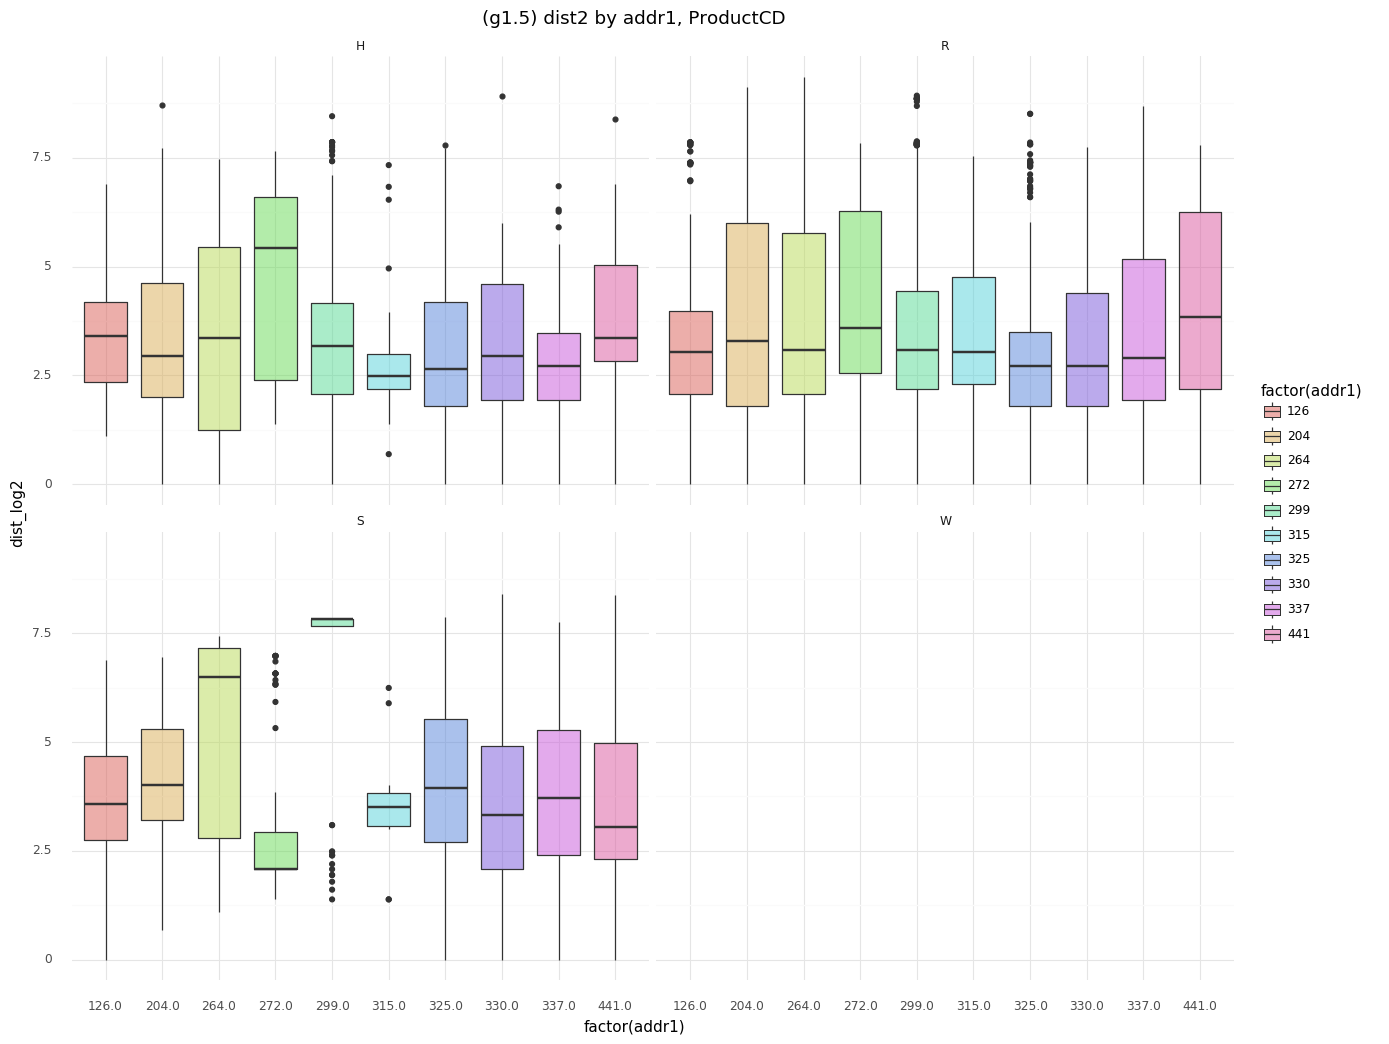

<ggplot: (-9223363305074456071)>


In [63]:
p = ggplot(tr, aes('factor(addr1)', y = 'dist_log2', fill = 'factor(addr1)' )) + geom_boxplot(alpha = 0.5) +   \
    theme_minimal() + ggtitle('(g1.5) dist2 by addr1, ProductCD') + facet_wrap('ProductCD') + theme(figure_size=(15, 12))
print(p)

(가설 2) S의 dist2가 낮을수록 fraud 증가?

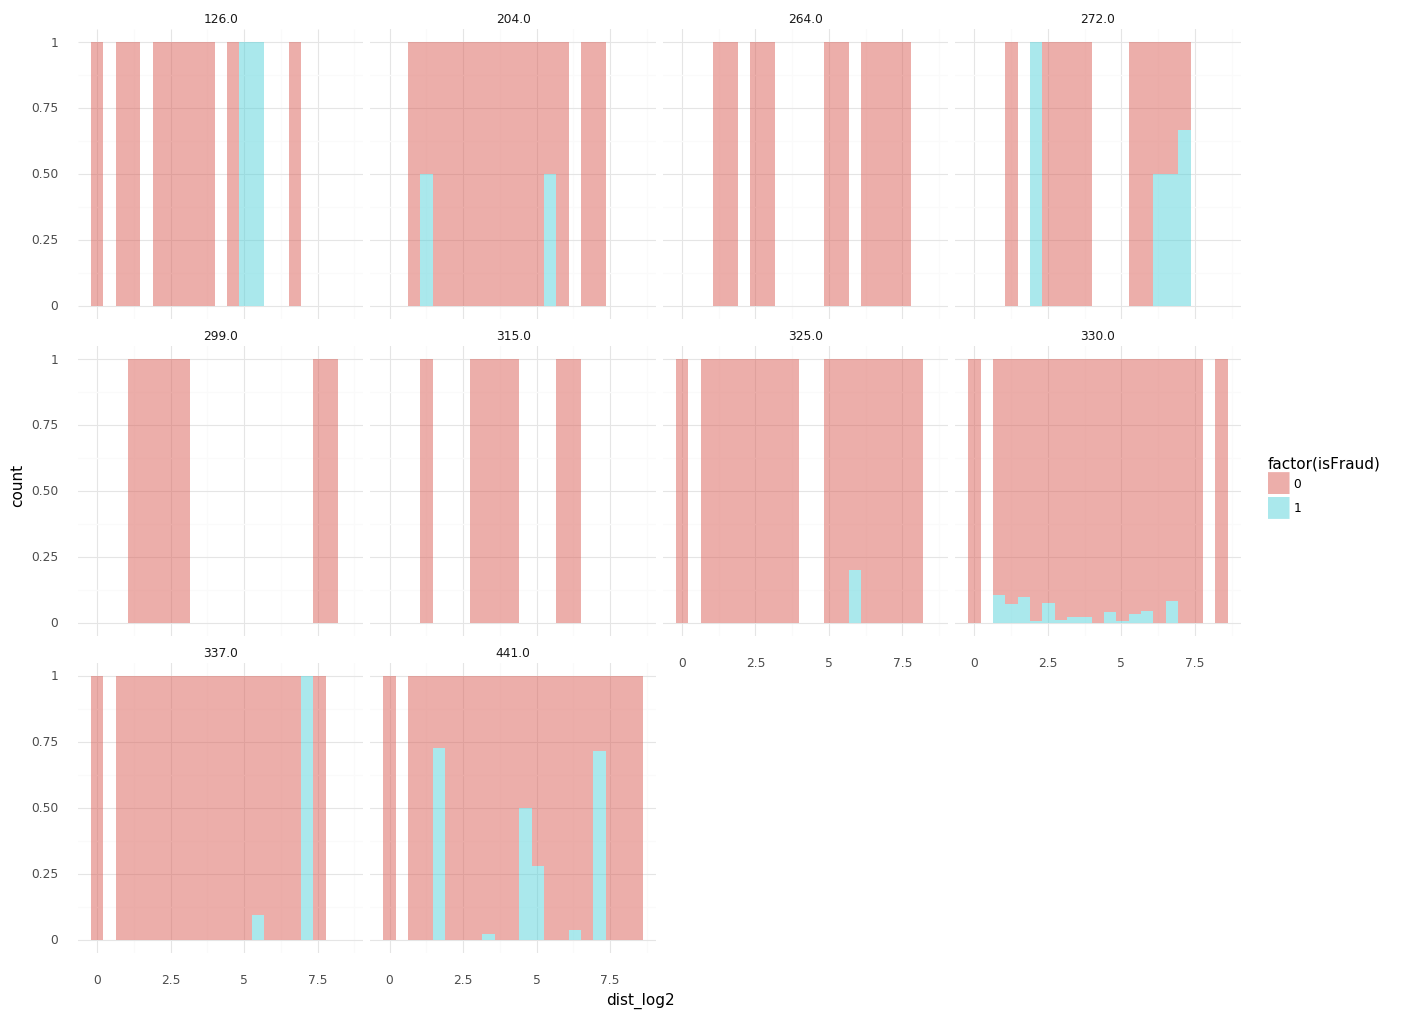

<ggplot: (-9223363305074514649)>

In [80]:
ex = tr[(tr['ProductCD']== 'S') ]
ex.shape
ggplot(ex[ex['dist_log2'].notnull()], aes('dist_log2', fill = 'factor(isFraud)')) + geom_histogram(alpha = 0.5, position = 'fill') + \
       theme_minimal() + facet_wrap('addr1') + theme(figure_size=(15, 12))

- dist2가 낮다고 fraud가 높아지지는 않음.  
- **단, 330을 제외하고 각 지역별로 fraud가 높은 일정 구간들이 존재**  
- **1) 따라서, dist2를 일정 구간별로  bining하고, addr1+addr2와 묶어 feature를 생성해 보는건?**
- **2) (가설 2) dist2가 billing region // 판매처의 ip address 간의 거리라면,  
  **예를들어 'A'라는 판매처가 사기 사이트라면 지역마다 시간대는 비슷하게, 하지만 지역별 A사이트와의 거리 차이는 있으니 dist 는 다르게 나타날 것이다.  이 관계들의 선/후행, 조합들을 통해 '사기사이트'를 체킹할 수는 없을까? -> 별도 아이디어로 빼서 진행하기**

### addr1 vs date

In [9]:
import datetime 

start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
tr['timeblock'] = tr['TransactionDT'].apply(lambda x: datetime.timedelta(seconds = x) + start_date ) 
te['timeblock'] = te['TransactionDT'].apply(lambda x: datetime.timedelta(seconds = x) + start_date ) 

tr['yearmonthday'] = (10000 * pd.to_datetime(tr['timeblock']).dt.year) + (100 * pd.to_datetime(tr['timeblock']).dt.month) + (1 * pd.to_datetime(tr['timeblock']).dt.day)
te['yearmonthday'] = (10000 * pd.to_datetime(te['timeblock']).dt.year) + (100 * pd.to_datetime(te['timeblock']).dt.month) + (1 * pd.to_datetime(te['timeblock']).dt.day)

tr['yearmonth'] = (100 * pd.to_datetime(tr['timeblock']).dt.year) + (1 * pd.to_datetime(tr['timeblock']).dt.month)
te['yearmonth'] = (100 * pd.to_datetime(te['timeblock']).dt.year) + (1 * pd.to_datetime(te['timeblock']).dt.month)

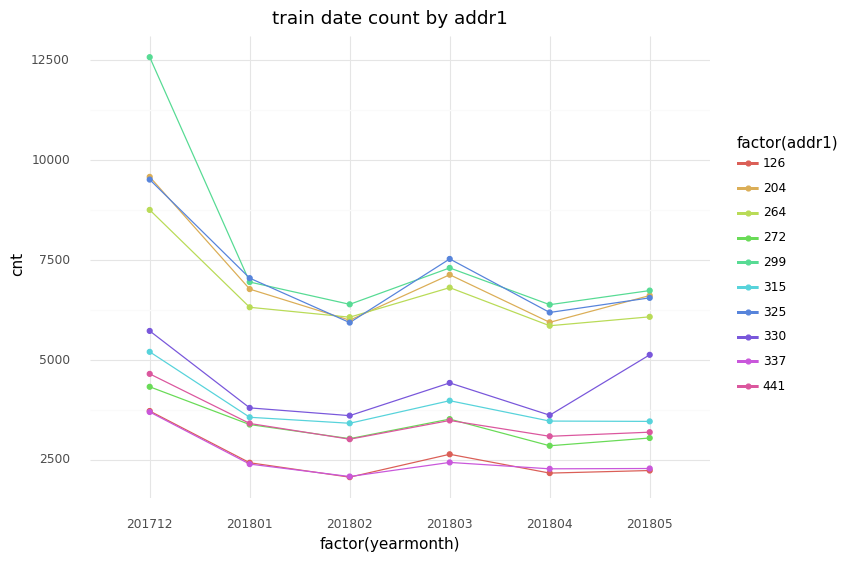

<ggplot: (-9223363266380358098)>


In [10]:
temp = tr.groupby(['yearmonth', 'addr1']).size().reset_index()
temp.columns = ['yearmonth', 'addr1', 'cnt']
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'cnt', group = 'factor(addr1)', color = 'factor(addr1)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (8, 6)) + ggtitle('train date count by addr1')
print(p)

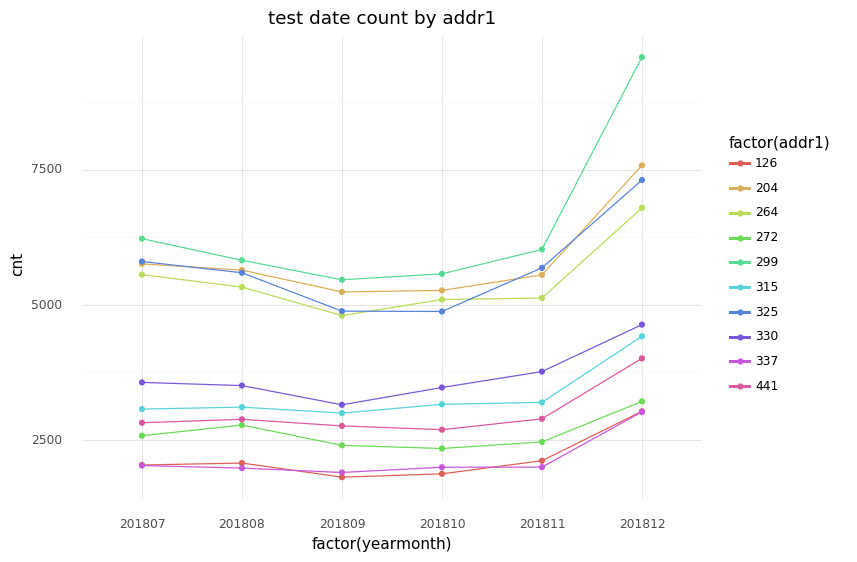

<ggplot: (8770474417903)>


In [11]:
temp = te.groupby(['yearmonth', 'addr1']).size().reset_index()
temp.columns = ['yearmonth', 'addr1', 'cnt']
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'cnt', group = 'factor(addr1)', color = 'factor(addr1)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (8, 6))  + ggtitle('test date count by addr1')
print(p)

- 대부분의 addr1이 월별로 비슷하게 증가/감소하는 패턴을 나타냈으나, 일부 지역의 경우 특정 월에 증가/감소폭이 두드러지는 경우가 발생  
- (가설) addr1 별 특정 월의 증가/감소폭이 큰 경우 Fraud도 연동되서 변하지않을까?


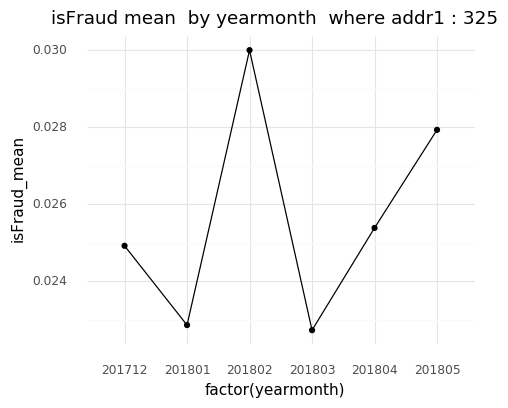

<ggplot: (-9223363266380398511)>


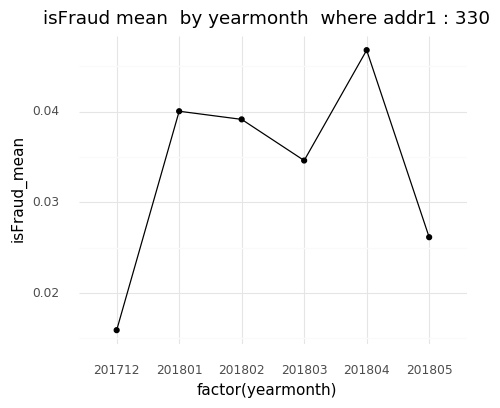

<ggplot: (-9223363266398394045)>


In [13]:
# 가설 확인
temp = tr[tr['addr1']==325]
temp = temp.groupby('yearmonth').isFraud.mean().reset_index()
temp.columns = ['yearmonth', 'isFraud_mean']
temp['var'] = 1
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'isFraud_mean', group = 'factor(var)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (5, 4)) + ggtitle('isFraud mean  by yearmonth  where addr1 : 325')
print(p)

temp = tr[tr['addr1']==330]
temp = temp.groupby('yearmonth').isFraud.mean().reset_index()
temp.columns = ['yearmonth', 'isFraud_mean']
temp['var'] = 1
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'isFraud_mean', group = 'factor(var)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (5, 4)) + ggtitle('isFraud mean  by yearmonth  where addr1 : 330')
print(p)

- 함부로 단정지을수는 없지만, 일부 케이스 중 거래량이 동월 다른 addr에 비해 급증하는 경우, fraud ratio는 감소하였음(ex. addr1 325의 3월, addr1 330의 5월)  
    - **addr 별 전달 대비 count 증감률 feature 생성**  
    - 단 여기서 문제는 train 첫달과, test 첫달은 값을 어떻게 기입하느냐인데..(특히 test 첫달은 train/test 사이 1달의 갭이 있어 전달을 구할수가없다..) 이를 해결하기 위해 train 첫달: test 마지막 달의 증감률 가지고오기 // test 첫달 : train 마지막달과 2달로 계산하여 기하평균내기  
    - And 거래량이 증가하는 경우 Fraud가 낮아진다는것은 무엇을 의미하는것일까? R, H, S 등은 주로 결제되는 시즌이 있을수도 있고.. 좀더 고민해볼 것  

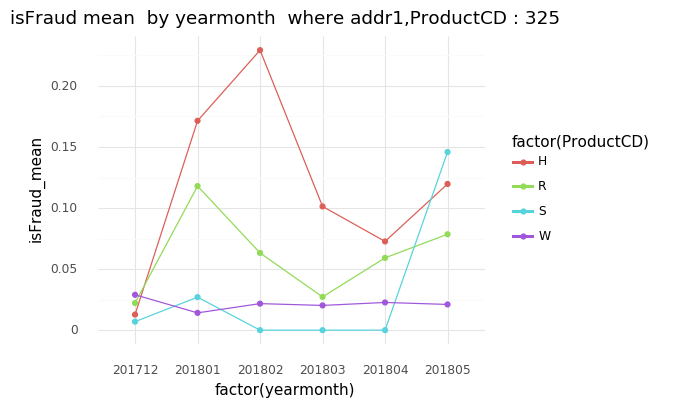

<ggplot: (-9223363266398361670)>


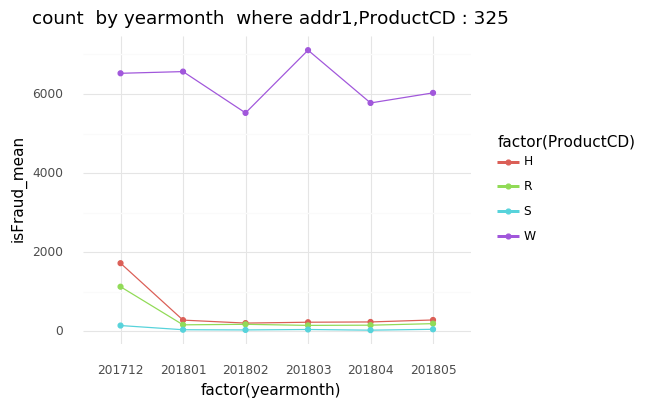

<ggplot: (8770456399592)>


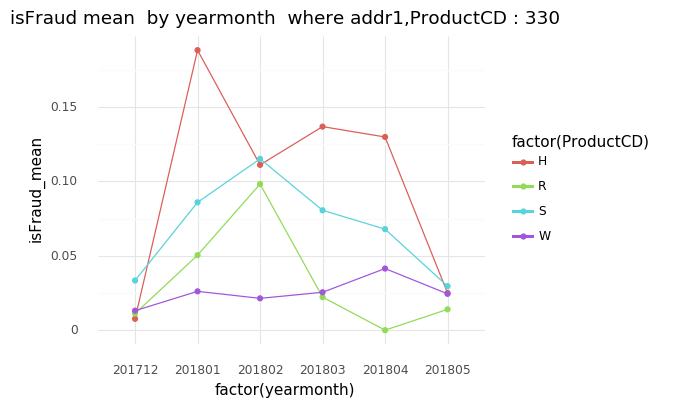

<ggplot: (-9223363266398395830)>


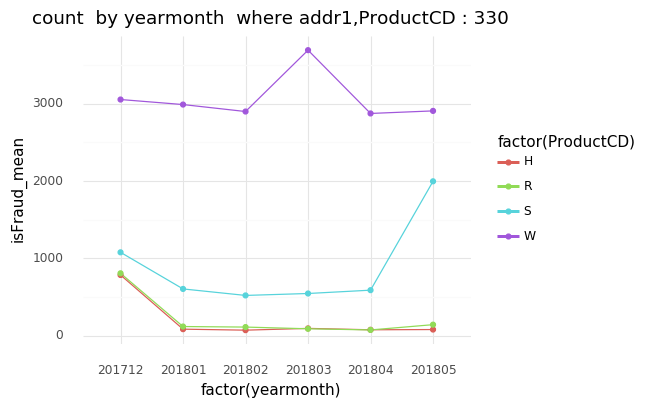

<ggplot: (-9223363266406067659)>


In [14]:
temp = tr[tr['addr1']==325]
temp = temp.groupby(['yearmonth','ProductCD']).isFraud.mean().reset_index()
temp.columns = ['yearmonth', 'ProductCD','isFraud_mean']
temp['var'] = 1
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'isFraud_mean', group = 'factor(ProductCD)', color = 'factor(ProductCD)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (5, 4)) + ggtitle('isFraud mean  by yearmonth  where addr1,ProductCD : 325')
print(p)

temp = tr[tr['addr1']==325]
temp = temp.groupby(['yearmonth','ProductCD']).isFraud.size().reset_index()
temp.columns = ['yearmonth', 'ProductCD','isFraud_mean']
temp['var'] = 1
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'isFraud_mean', group = 'factor(ProductCD)', color = 'factor(ProductCD)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (5, 4)) + ggtitle('count  by yearmonth  where addr1,ProductCD : 325')
print(p)

temp = tr[tr['addr1']==330]
temp = temp.groupby(['yearmonth','ProductCD']).isFraud.mean().reset_index()
temp.columns = ['yearmonth', 'ProductCD','isFraud_mean']
temp['var'] = 1
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'isFraud_mean', group = 'factor(ProductCD)', color = 'factor(ProductCD)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (5, 4)) + ggtitle('isFraud mean  by yearmonth  where addr1,ProductCD : 330')
print(p)

temp = tr[tr['addr1']==330]
temp = temp.groupby(['yearmonth','ProductCD']).isFraud.size().reset_index()
temp.columns = ['yearmonth', 'ProductCD','isFraud_mean']
temp['var'] = 1
p = ggplot(temp, aes(x = 'factor(yearmonth)', y = 'isFraud_mean', group = 'factor(ProductCD)', color = 'factor(ProductCD)')) + geom_line() + geom_point() +\
      theme_minimal() + theme(figure_size = (5, 4)) + ggtitle('count  by yearmonth  where addr1,ProductCD : 330')
print(p)

- 앞선 feature에 더해서 addr, ProductCD 별로 전달 대비 증감률을 feature로 만들어봐도 좋을듯하다.

### addr vs card1

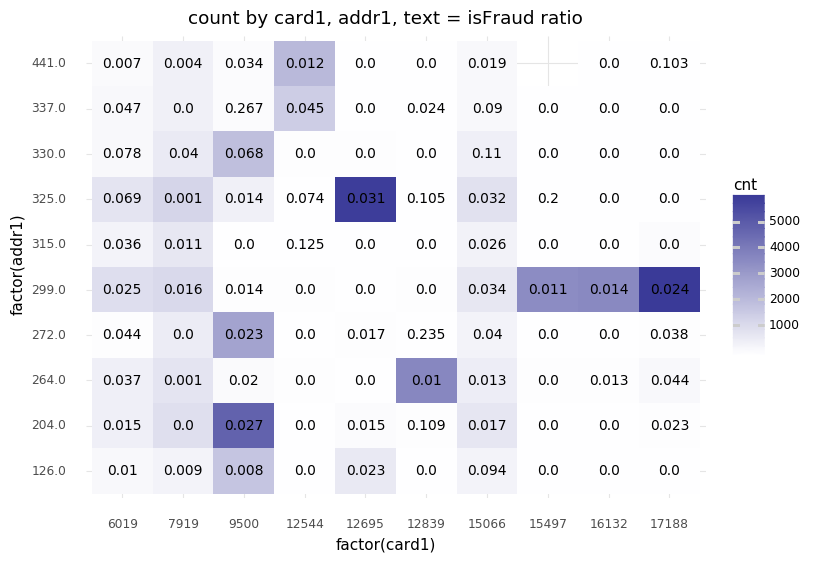

<ggplot: (-9223363266398376083)>


In [16]:
ex = tr.groupby('card1').size().nlargest(10).reset_index()
ex.columns = ['card1', 'cnt']
id2 =ex['card1'].values.tolist()

temp = tr[tr['card1'].isin(id2)]
temp = temp.groupby(['card1','addr1']).agg({'isFraud': ['count', 'mean']}).reset_index()
temp.columns = ['card1', 'addr1', 'cnt', 'prop']
temp['prop'] = round(temp['prop'], 3)
p = ggplot(temp, aes(x='factor(card1)', y='factor(addr1)', fill='cnt')) +   geom_tile(alpha = 1) + theme_minimal() + \
        geom_text(aes(label='factor(prop)'), size=10) + scale_fill_gradient2() + theme(figure_size = (8, 6)) +\
        ggtitle("count by card1, addr1, text = isFraud ratio")
print(p)

- addr별로 사용량이 많은 카드들이 존재하며, 이 경우 전반적으로 낮은 fraud가, 이외 card들은 상대적으로 fraud가 높아지는 경향이 보임
    - feature 추가 : addr별 card count prop를 넣어주는건?? 이 값이 높을수록 addr의 주 사용 카드이므로 fraud는 낮아질것임
    - 시간...별로 트렌드가 변하지는않으려나? monthly, 혹인 이전 대비 성장률 등등을 통해 feature를만들수는? -> 추가 아이디어로 고민해보기
    - 여기에 card1 count도 녹일수는없을까? 즉, addr에 비중이 작은 card1이 있지만, 이 카드가 많이 사용되는 카드라면 이를 보정해줄수있는..??
    - 이건 정말 '만약'인데, 특정 addr, card 에서만 높은 값을 가지는 건 지역 특화 카드이지않을까? 그렇다면 지역특화 카드 특성 반영?
        (예를들어 지역특화카드라면, dist가 작은 값들은 fraud가 작을 가능성이 높겠지...라던가 등) -> 추가 아이디어 고민해보기